In [135]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from livelossplot import PlotLossesKeras
from keras import backend as K
import tensorflow as tf
import keras.optimizers as opts
from keras.layers.core import Dropout

In [138]:
df = pd.read_csv('../../data/SECOP_Electronicos_Cleaned.csv').drop(['NormalizedDelay','Delayed','Unnamed: 0','Nombre Entidad','Dias Adicionados',
                                                                                                'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato'], axis=1)

In [139]:
df.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Es Grupo', 'Es Pyme', 'Obligación Ambiental',
       'Obligaciones Postconsumo', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Amortizado', 'EsPostConflicto',
       'Destino Gasto', 'PGN', 'SGP', 'SGR', 'RP_AGR', 'RP_NO_AGR', 'RC',
       'Delay', 'Days_to_end_of_year'],
      dtype='object')

In [140]:
print('The shape of the dataset result of data cleaning is : ' + str(df.shape))

The shape of the dataset result of data cleaning is : (1562161, 27)


In [141]:
#Convert the variables to its corresponding data type
cat_cols = ['Departamento', 'Orden', 'Sector', 'Rama','Entidad Centralizada', 'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
            'Es Grupo','Es Pyme', 'Destino Gasto', 'EsPostConflicto','Obligaciones Postconsumo','Obligación Ambiental', 'Delay']
cat_values = {key:'category' for key in cat_cols}
df = df.astype(cat_values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562161 entries, 0 to 1562160
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Departamento               1562161 non-null  category
 1   Orden                      1562161 non-null  category
 2   Sector                     1562161 non-null  category
 3   Rama                       1562161 non-null  category
 4   Entidad Centralizada       1562161 non-null  category
 5   Estado Contrato            1562161 non-null  category
 6   Tipo de Contrato           1562161 non-null  category
 7   Modalidad de Contratacion  1562161 non-null  category
 8   Es Grupo                   1562161 non-null  category
 9   Es Pyme                    1562161 non-null  category
 10  Obligación Ambiental       1562161 non-null  category
 11  Obligaciones Postconsumo   1562161 non-null  category
 12  Valor del Contrato         1562161 non-null  int64   
 1

In [142]:
DelayZero_rows = len(df[df['Delay']==0])
print('The number of rows with Delay = 0 is : ' + str(DelayZero_rows))

# Rows to delete in downsampling
rows_to_delete = int(0.9*DelayZero_rows)

# Select all indices
candidate_indices = df[df['Delay']==0].index 

# Randomly Select 35% of all indices
candidate_indices = np.random.choice(candidate_indices, size = rows_to_delete, replace = False) 
df_DownSampling = df.drop(candidate_indices)

print('\n')
print('New dataset after downsampling')
print(df_DownSampling.Delay.value_counts())
print('\n')
print('Dataset before downsampling')
print(df.Delay.value_counts())


The number of rows with Delay = 0 is : 1330540


New dataset after downsampling
1    144286
0    133054
2     63713
3     23622
Name: Delay, dtype: int64


Dataset before downsampling
0    1330540
1     144286
2      63713
3      23622
Name: Delay, dtype: int64


In [143]:
df = df_DownSampling

In [144]:
# Y vector
y = df['Delay'].astype('category')

In [145]:
# X Matrix
X = df.drop(['Delay'], axis=1)

# Codification of predictor variables
X.Departamento = X.Departamento.cat.codes
X.Orden = X.Orden.cat.codes
X.Sector = X.Sector.cat.codes
X.Rama = X.Rama.cat.codes
X['Entidad Centralizada'] = X['Entidad Centralizada'].cat.codes
X['Estado Contrato'] = X['Estado Contrato'].cat.codes
X['Tipo de Contrato'] = X['Tipo de Contrato'].cat.codes
X['Modalidad de Contratacion'] = X['Modalidad de Contratacion'].cat.codes
X['Es Grupo'] = X['Es Grupo'].cat.codes
X['Es Pyme'] = X['Es Pyme'].cat.codes
X['Destino Gasto'] = X['Destino Gasto'].cat.codes
X['EsPostConflicto'] = X['EsPostConflicto'].cat.codes
X['Obligaciones Postconsumo'] = X['Obligaciones Postconsumo'].cat.codes
X['Obligación Ambiental'] = X['Obligación Ambiental'].cat.codes

In [146]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [147]:
# Normalization of predictor variables (X) with StandardScaler function
from sklearn.preprocessing import StandardScaler

# StandardScaler funtion 
scaler = StandardScaler()
scaler.fit(X)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=pd.DataFrame(X_train).columns, index=pd.DataFrame(X_train).index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=pd.DataFrame(X_test).columns, index=pd.DataFrame(X_test).index)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [148]:
# Definition of output dimensions, dependent variable
output_var = np.unique(y_train).shape[0]
print(output_var, ' output variables')
# Definition of input dimensions, predictor variables
dims = X_train.shape[1]
print(dims, 'input variables')

4  output variables
26 input variables


In [149]:
K.clear_session()

# The NN is defined with Sequential() mode
model = Sequential()
# Definition of layer with an output size equal to output_var and an input_shape of dims
model.add( Dense(16, input_shape=(dims,), activation='relu') )
#model.add(Dropout(0.1))
#model.add(Dense(8,activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(output_var,activation='softmax'))

# Neural Network architecture
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                432       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________
None


In [152]:
# Definition of loss function. SparseCategoricalCrossentropy is used since it is a Multi-class classification exercise.
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy())

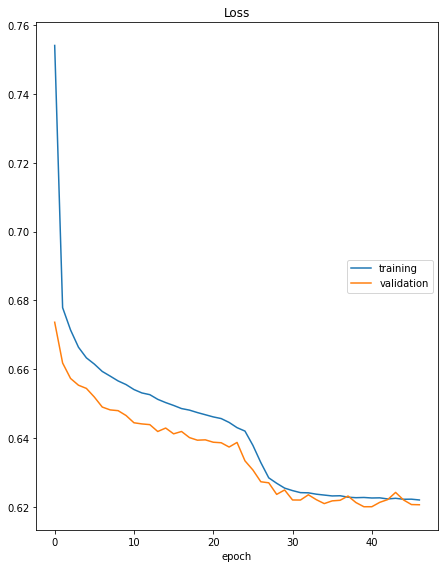

Loss
	training         	 (min:    0.622, max:    0.754, cur:    0.622)
	validation       	 (min:    0.620, max:    0.674, cur:    0.621)
7636/7636 [==============================] - 11s 1ms/step - loss: 0.6220 - val_loss: 0.6206
Epoch 48/50
2130/7636 [=======>......................] - ETA: 5s - loss: 0.6162

In [ ]:
# Neural Network training during 50 epochs

# This cell takes time to run 

model.fit(X_train, y_train, 
          verbose=1, 
          epochs=50, 
          validation_data=(X_test, y_test),
          callbacks=[PlotLossesKeras()])

In [ ]:
# This cell takes time to run 
y_pred = model.predict(X_test)

In [160]:
print(y_pred.shape)
pd.DataFrame(y_pred).head(10)

(120343, 5)


,0,1,2,3,predict
0,0.037942,0.404549,0.538585,0.018924,2
1,0.088435,0.651478,0.252828,0.007260,1
2,0.012503,0.604186,0.367455,0.015856,1
3,0.971521,0.017877,0.003163,0.007440,0
4,0.999579,0.000328,0.000021,0.000073,0
5,0.040986,0.579555,0.370114,0.009345,1
6,0.993881,0.005493,0.000405,0.000221,0
7,0.262282,0.646269,0.078042,0.013407,1
8,0.955021,0.041541,0.002011,0.001427,0
9,0.070629,0.753084,0.163812,0.012475,1


In [ ]:
y_pred = pd.DataFrame(y_pred)
def final_predict(row):
    return row.astype('float').argmax()

y_pred['predict'] = y_pred[[0,1,2,3]].apply(lambda row: final_predict(row), axis=1)

In [161]:
y_pred.predict.value_counts()

1    59757
0    38511
2    14327
3     7748
Name: predict, dtype: int64

In [162]:
metrics.f1_score(y_pred.predict.to_numpy(), y_test, average= 'macro')

0.6626726218935676